In [760]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import math 
%matplotlib inline

In [762]:
def create_kernel_matrix(kernelfunc, size):
    return np.fromfunction(lambda i, j: kernelfunc(i, j), (size, size))
    + np.identity(size) * 1e-4  # make matrix diagonally dominant. 

In [763]:
def create_normal_distribution(kernel): 
    mu, cov = np.zeros(tf.shape(kernel).numpy()[0]), tf.linalg.inv(kernel)
    scale = tf.linalg.cholesky(cov)
    return tfp.distributions.MultivariateNormalTriL(loc=mu,scale_tril=scale)

In [764]:
def sampleRKHS(kernelfunc, dsize=10, ssize=12, rkhs_range=(-4,-4), func_precision=100):
    """
    kernelfunc - lambda func that defines the kernel matrix of size dsize x dsize
    dsize - number of elements in the original dataset. 
    ssize - sample size, how many functions from RKHS to sample
    rkhs_range - what range to display the RKHS functions on
    func_precision - how many points to genereate in the rkhs_range (to draw lines) i.e resolution of lines

    returns X, Y -> X: domain values with shape(func_precision, ssize) Y: y values sampled RKHS functions 
    shape(func_precision, ssize) each col represents x and y values of each sampled function. 
    """
    kernel_matrix = create_kernel_matrix(kernelfunc, dsize) 
    mvn = create_normal_distribution(kernel_matrix) 
    xi = np.linspace(rkhs_range[0], rkhs_range[1], func_precision) # this will be the domain 
                                                                   # we will be looking at of the RKHS space. 
    # create a matrix that will store the domains of the sampled value (linespace).
    # each column will be the same since we are analyzing them in the same domain.  
    y = np.reshape(xi.T, (xi.shape[0], 1)) # create a transpose of x (since each col will represent the points we are eval at)

    # create a matrix that will store the domains of the sampled value (linespace).
    # each column will be the same since we are analyzing them in the same domain.  
    y = np.reshape(xi.T, (xi.shape[0], 1)) # create a transpose of x (since each col will represent the points we are eval at)
    X = y
    for i in range (0, ssize-1): # range == # of datums in original dataset. 
        X = np.concatenate((X, y), axis=1)

    # create functions evaluated at the 10 different basis functions 
    # each basis function is a kernel evaluated at each point holding second variable constant. 
    # in this case we are evaluating the second variable at (almost) all possible points (large number of rows representing domain)
    Kx = np.zeros((X.shape[0], dsize))
    for i in range(Kx.shape[0]): 
        for j in range(Kx.shape[1]): 
            Kx[i, j] = gausskernel(j - dsize / 2 - 1, X[i, j])  # change to i - m - 1 
    
    # now create the weighted functions now representing the actual functions in RKHS. 
    alphas = mvn.sample([ssize]).numpy() # sample the alpha weights by which each kernel function will be weighed. 
    # each fx will need its own alpha. Amount sampled is the amount of sample functions we want to generate. 
    Fx = np.matmul(Kx, alphas.T)
    return X, Fx


In [766]:
# Define the Guassian Kernel
t = 0.5
c = .001
gausskernel = lambda i, j: c * np.exp( (-1.0 /  ( 2.0 * t**2 )) * (i - j)**2 )

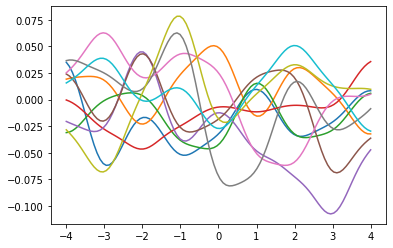

In [767]:
x, y = sampleRKHS(gausskernel)
for i in range(0, 10): 
    plt.plot(X[:, i], Fx[:, i])